<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/limitPDCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [22]:
# Import dataset
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/PDCurves.csv')

# Selection for post 2017
df = df.query('Year >= 2017')
df = df.dropna(axis = 1, how = 'all') #Drop missing columns
df

,Segment,Aging,Year,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
3,CU,0,2017,325631,0.000049,0.000126,0.000694,0.002024,0.003535,0.005239,0.007008,0.008869,0.010761,0.012588,0.014329,0.016132,0.017894,0.019666,0.021438,0.023124,0.024807,0.026469,0.028026,0.029573,0.031161,0.032706,0.034152,0.035411
4,CU,0,2018,326584,0.000043,0.000101,0.000545,0.001990,0.003647,0.005447,0.007288,0.009207,0.011213,0.013320,0.015423,0.017456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CU,1,2017,37544,0.000240,0.009136,0.028074,0.043762,0.058012,0.070983,0.083795,0.094902,0.105716,0.115837,0.125293,0.133736,0.141913,0.149638,0.156696,0.163941,0.170467,0.176673,0.182506,0.187993,0.193213,0.197848,0.202456,0.206158
9,CU,1,2018,38648,0.000129,0.006520,0.026780,0.043133,0.057079,0.070715,0.083859,0.096253,0.107276,0.117341,0.127251,0.136799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,CU,2,2017,15407,0.028234,0.091322,0.125073,0.154605,0.180437,0.203674,0.222042,0.238723,0.253716,0.266762,0.278834,0.290323,0.300902,0.310638,0.319595,0.327059,0.333939,0.340819,0.347050,0.352762,0.358019,0.362887,0.367755,0.372363
14,CU,2,2018,14831,0.021239,0.095071,0.134785,0.167150,0.198301,0.225541,0.247792,0.266267,0.283123,0.299103,0.312117,0.323174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,CU,3,2017,3005,0.421298,0.521464,0.585025,0.624293,0.659900,0.684526,0.703494,0.717138,0.729784,0.740433,0.748419,0.756739,0.764060,0.770383,0.775707,0.782363,0.788353,0.792679,0.797005,0.801997,0.805657,0.809651,0.813311,0.815308
19,CU,3,2018,2886,0.433125,0.525295,0.578656,0.616771,0.644491,0.665281,0.683992,0.699584,0.716216,0.728344,0.737699,0.745322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,HU,0,2017,879753,0.000050,0.000120,0.000464,0.001371,0.002355,0.003361,0.004398,0.005496,0.006590,0.007666,0.008710,0.009740,0.010773,0.011835,0.012881,0.013939,0.014953,0.015936,0.016864,0.017761,0.018613,0.019463,0.020289,0.021008
24,HU,0,2018,774931,0.000055,0.000125,0.000422,0.001419,0.002552,0.003760,0.005004,0.006297,0.007581,0.008905,0.010234,0.011571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Define plot function
def plotPD(data, average = True, year = True, proxy = None):
  with plt.style.context('seaborn'):
    fig, axs = plt.subplots(1, 2, figsize = (20, 6), sharey = True)
    axs = axs.ravel()
    for i, segment in enumerate(data['Segment'].unique()):

      # Data selection
      selectData = data[data['Segment'] == segment]
      if average is True and year is True:
        selectData = pd.melt(selectData.drop(['Segment', 'N'], axis = 1),
                           id_vars = ['Year'],
                           var_name = 'times', value_name = 'badRate')
        huePlot, stylePlot = 'Year', None
        selectData['times'] = selectData['times'].astype(np.int8) #For better plot
        selectData = selectData.sort_values(by = ['Year', 'times'])
      elif average is True and year is False:
        if proxy is not None:
          selectData = pd.melt(selectData,
                               id_vars = ['Segment'],
                               var_name = 'times', value_name = 'badRate')
        else:
          selectData = pd.melt(selectData.drop(['N'], axis = 1),
                            id_vars = ['Segment'],
                            var_name = 'times', value_name = 'badRate')
        huePlot, stylePlot = None, None
        selectData['times'] = selectData['times'].astype(np.int8) #For better plot
        selectData = selectData.sort_values(by = ['times'])
      elif average is False and year is True:
        selectData = pd.melt(selectData.drop(['N'], axis = 1),
                            id_vars = ['Segment', 'Aging', 'Year'],
                            var_name = 'times', value_name = 'badRate')
        huePlot, stylePlot = 'Aging', 'Year'
        selectData['times'] = selectData['times'].astype(np.int8) #For better plot
        selectData = selectData.sort_values(by = ['Aging', 'Year', 'times'])

      # Plot
      fig.suptitle(f'Cumulative PD Post-2017')
      sns.lineplot(x = 'times', y = 'badRate', data = selectData,
                  hue = huePlot, style = stylePlot, legend = 'full',
                  palette = 'viridis', ci = None, ax = axs[i])
      axs[i].set_title(f'Segment: {segment}')
      axs[i].set(xlabel = 'Time', ylabel = 'PD')
  return plt.show()

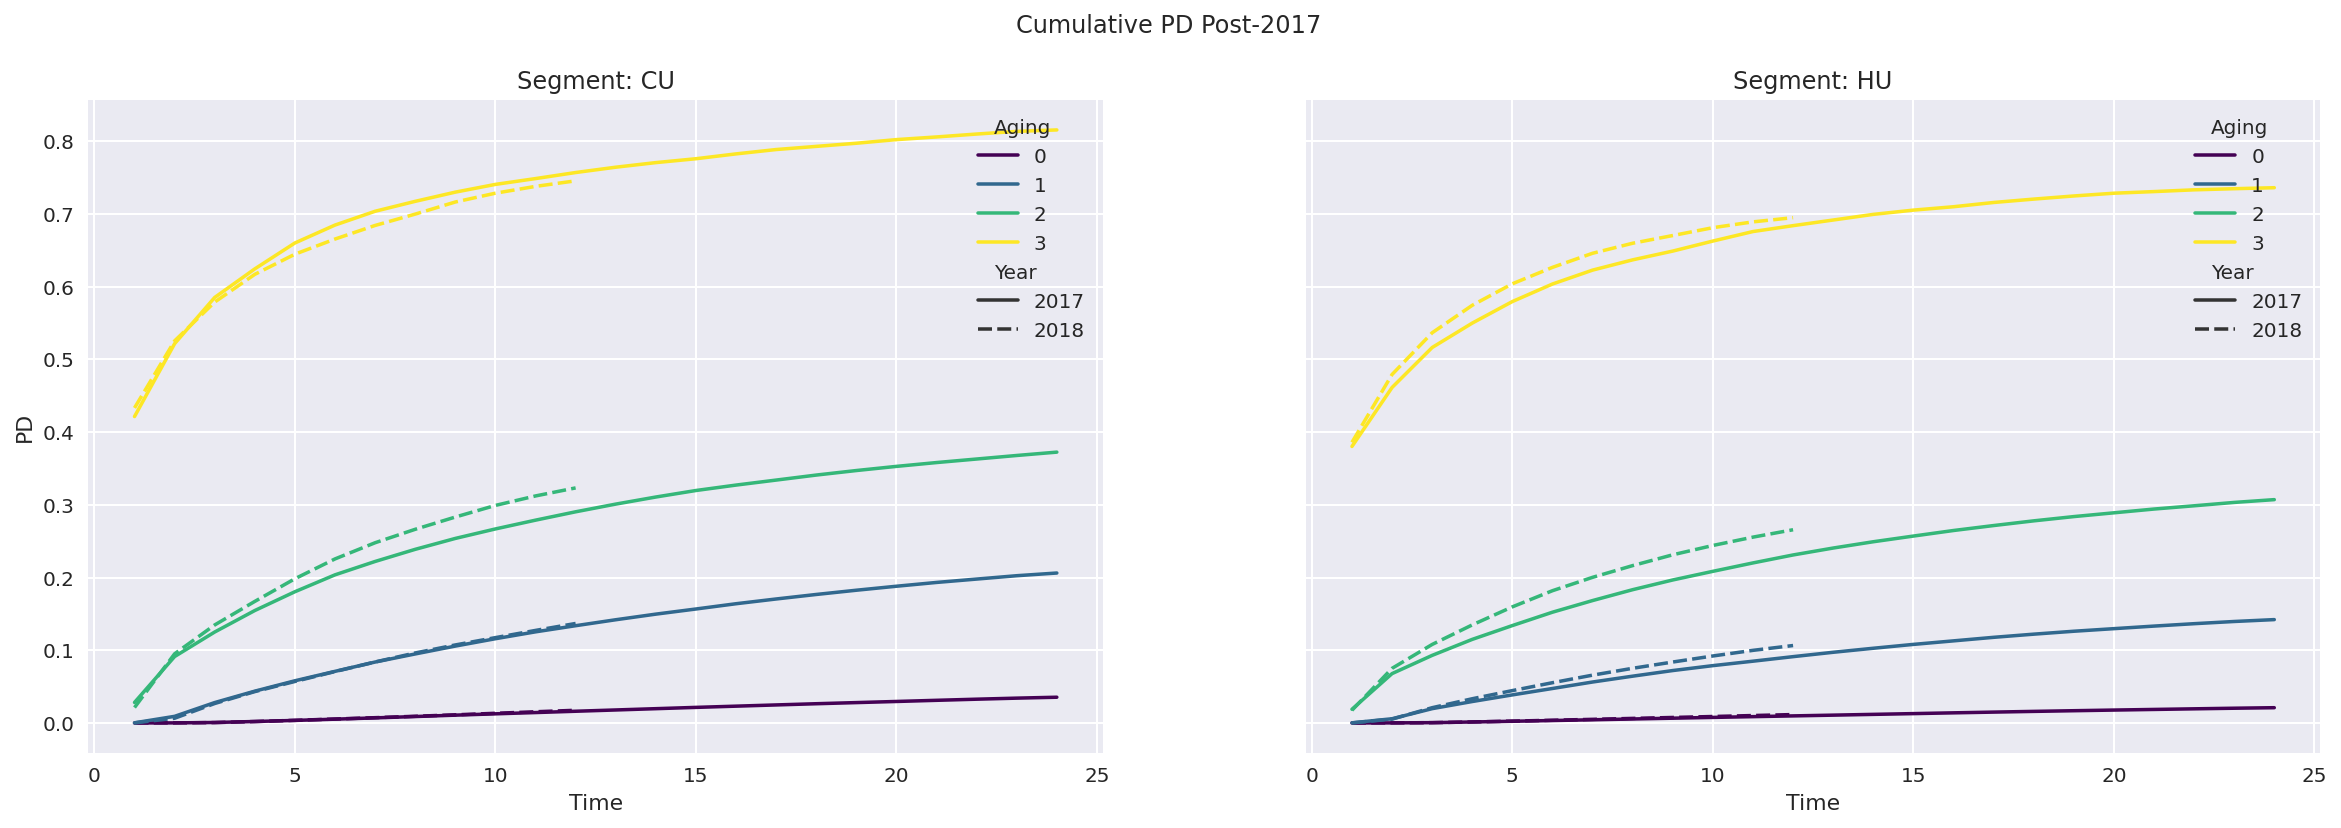

In [24]:
# Plot PD of post-2017
plotPD(df, average = False, year = True)

In [25]:
# Define wide table weighted average function
# Combine all risk grade and weighted by years
def weightedAverage(data, level):
  if level == 'Year':
    averageResult = []
    for i in data.columns[4:]:
      selectData = data[['Segment', 'Year', 'N', i]].dropna() #Drop missing PD
      average = selectData.groupby(['Segment', 'Year']).apply(lambda x: np.average(x[i], weights = x['N']))
      average = average.rename(i)
      averageResult.append(average)
    averageResult = pd.concat(averageResult, axis = 1).reset_index()
    averageResult['N'] = list(data.groupby(['Segment', 'Year'])['N'].sum()) #Get total number by segment
    cols = averageResult.columns
    cols = cols[0:2].append(cols[-1:]).append(cols[2:-1]) #Rearrange columns
    averageResult = averageResult[cols]
  if level == 'Segment':
    averageResult = []
    for i in data.columns[3:]:
      selectData = data[['Segment', 'N', i]]
      average = selectData.groupby(['Segment']).apply(lambda x: np.average(x[i], weights = x['N']))
      average = average.rename(i)
      averageResult.append(average)
    averageResult = pd.concat(averageResult, axis = 1).reset_index()
    averageResult['N'] = list(data.groupby(['Segment'])['N'].sum()) #Get total number by segment
    cols = averageResult.columns
    cols = cols[0:1].append(cols[-1:]).append(cols[1:-1]) #Rearrange columns
    averageResult = averageResult[cols]
  return averageResult

In [26]:
# Weighted average by year
averageDF = weightedAverage(df, level = 'Year')
averageDF

,Segment,Year,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,CU,2017,381587,0.004523,0.008800,0.013011,0.017191,0.021206,0.025069,0.028730,0.032192,0.035575,0.038741,0.041707,0.044606,0.047399,0.050114,0.052725,0.055230,0.057633,0.059973,0.062161,0.064292,0.066402,0.068404,0.070317,0.071957
1,CU,2018,382949,0.004136,0.008385,0.012748,0.017172,0.021408,0.025531,0.029430,0.033151,0.036752,0.040274,0.043643,0.046826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HU,2017,1005953,0.002926,0.005668,0.008343,0.010938,0.013410,0.015823,0.018158,0.020407,0.022559,0.024568,0.026482,0.028343,0.030136,0.031881,0.033553,0.035186,0.036757,0.038239,0.039621,0.040911,0.042151,0.043346,0.044495,0.045486
3,HU,2018,883185,0.002816,0.005736,0.008718,0.011723,0.014641,0.017469,0.020146,0.022682,0.025079,0.027420,0.029660,0.031756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


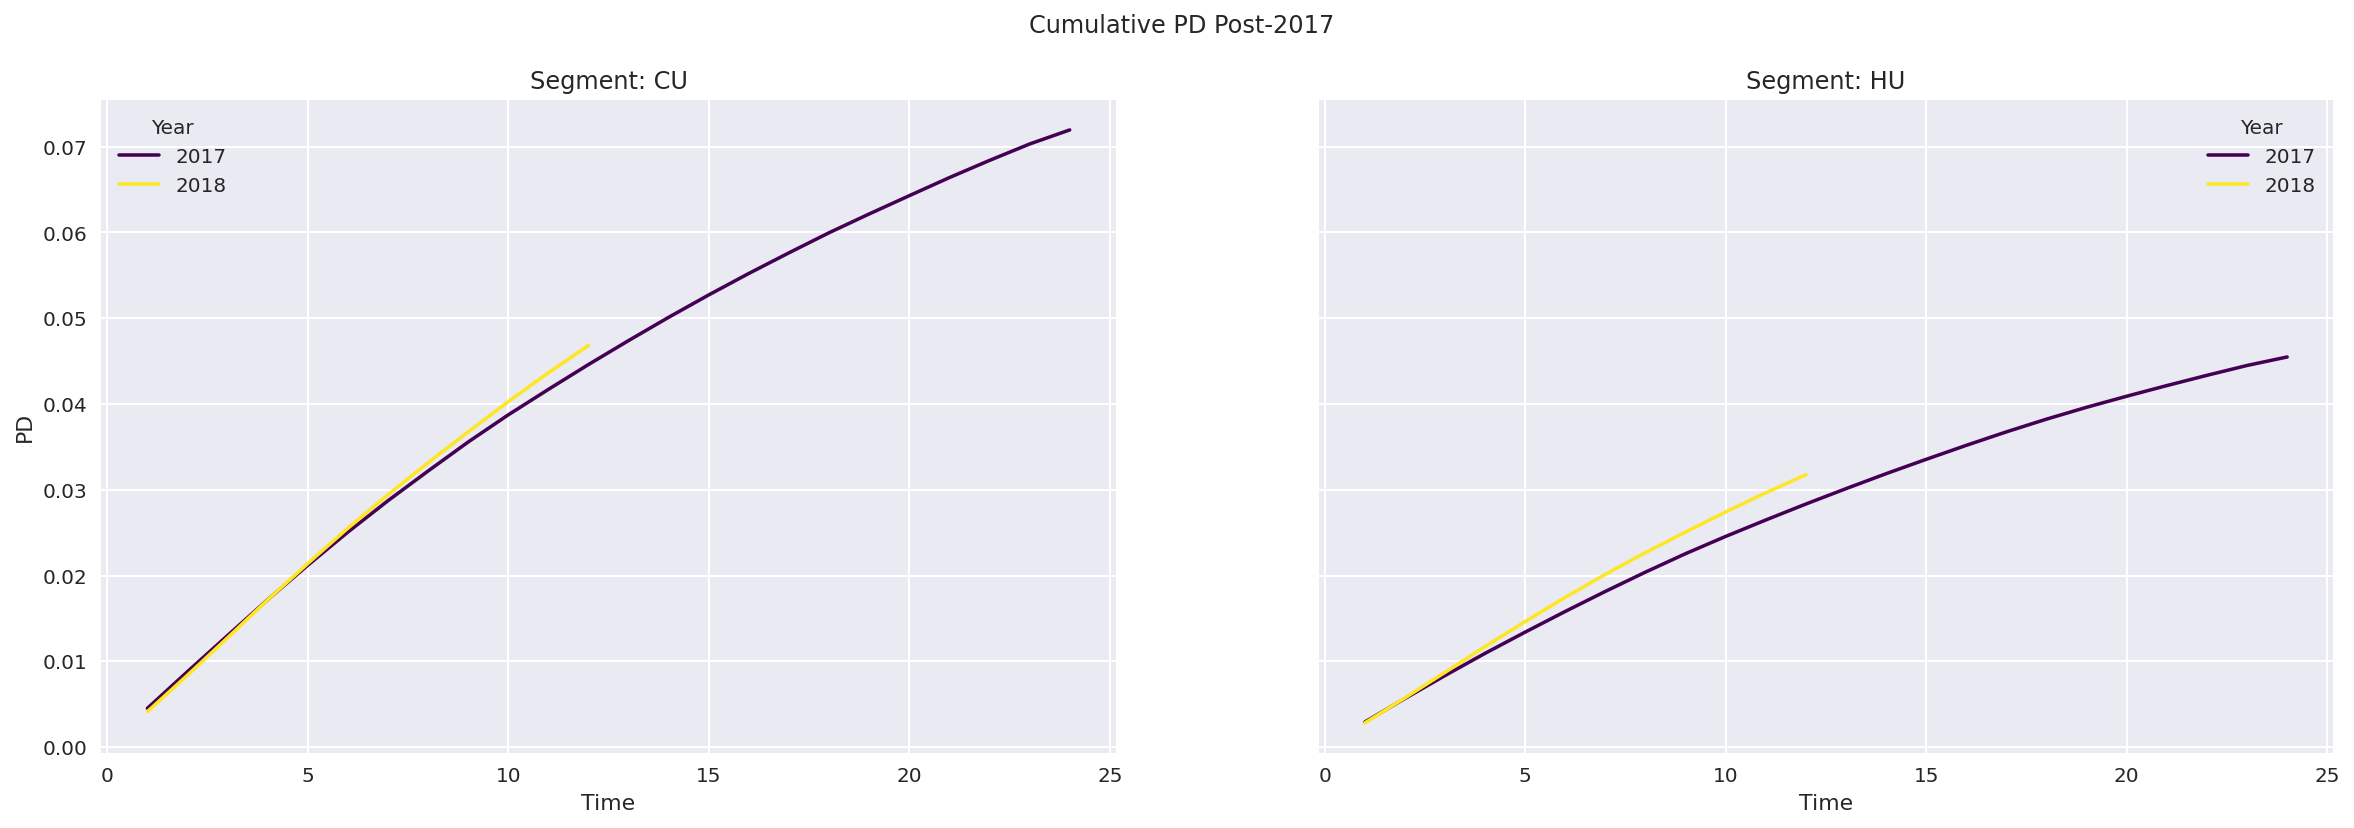

In [27]:
# Plot weighted average PD of post-2017
plotPD(averageDF, average = True, year = True)

In [28]:
# Chain-ladder
# Calculate development factor
factors = []

for segment in averageDF['Segment'].unique():

    # Calculate development factor by year
    data = averageDF[averageDF['Segment'] == segment]
    data = data.drop(['Segment', 'Year'], axis = 1)
    for i in range(data.shape[1] - 1):

      # Break statement i can be maximum as 58 since forward data will be column 60
      if i > data.shape[1] - 3:
        break

      forward = data.iloc[:, i + 2] #Select forward time
      if forward.isnull().any() == True:
        current = data.iloc[0:forward.count(), i + 1] #Select current avaliable based on forward
        factor = np.nansum(forward * data.iloc[:, 0]) / np.nansum(current * data.iloc[:, 0]) #df[,:0] is number of observation
        factors.append(factor)
      else:
        pass #No missing value don't need to calculate factor

# Format shape of development factors
factors = np.array(factors)
factors = factors.reshape(averageDF['Segment'].nunique(), -1) #Reshape by segment

In [29]:
# Imputation with factors
dfImputed = []

for s, segment in enumerate(averageDF['Segment'].unique()):

  # Select data by segment and risk grade
  data = averageDF[averageDF['Segment'] == segment]
  data = data.set_index(['Segment', 'Year', 'N']) #Set index to keep information

  # Select factor by segment and risk grade
  factor = factors[s] 

  for i in range(data.shape[1]):
    for j in range(data.shape[0]):
      if pd.isnull(data.iloc[j, i]):
        data.iloc[j, i] = data.iloc[j, i - 1] * factor[i - 12] #12 means the first 12 index do not need to be filled
      else:
        pass

  # Append result   
  dfImputed.append(data)

# Format to DataFrame
dfImputed = pd.concat(dfImputed, axis = 0, ignore_index = False)
dfImputed = dfImputed.reset_index()
dfImputed.head(5)

,Segment,Year,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,CU,2017,381587,0.004523,0.008800,0.013011,0.017191,0.021206,0.025069,0.028730,0.032192,0.035575,0.038741,0.041707,0.044606,0.047399,0.050114,0.052725,0.055230,0.057633,0.059973,0.062161,0.064292,0.066402,0.068404,0.070317,0.071957
1,CU,2018,382949,0.004136,0.008385,0.012748,0.017172,0.021408,0.025531,0.029430,0.033151,0.036752,0.040274,0.043643,0.046826,0.049759,0.052609,0.055349,0.057979,0.060502,0.062958,0.065256,0.067492,0.069707,0.071809,0.073817,0.075539
2,HU,2017,1005953,0.002926,0.005668,0.008343,0.010938,0.013410,0.015823,0.018158,0.020407,0.022559,0.024568,0.026482,0.028343,0.030136,0.031881,0.033553,0.035186,0.036757,0.038239,0.039621,0.040911,0.042151,0.043346,0.044495,0.045486
3,HU,2018,883185,0.002816,0.005736,0.008718,0.011723,0.014641,0.017469,0.020146,0.022682,0.025079,0.027420,0.029660,0.031756,0.033764,0.035719,0.037593,0.039422,0.041182,0.042843,0.044391,0.045837,0.047226,0.048564,0.049852,0.050962


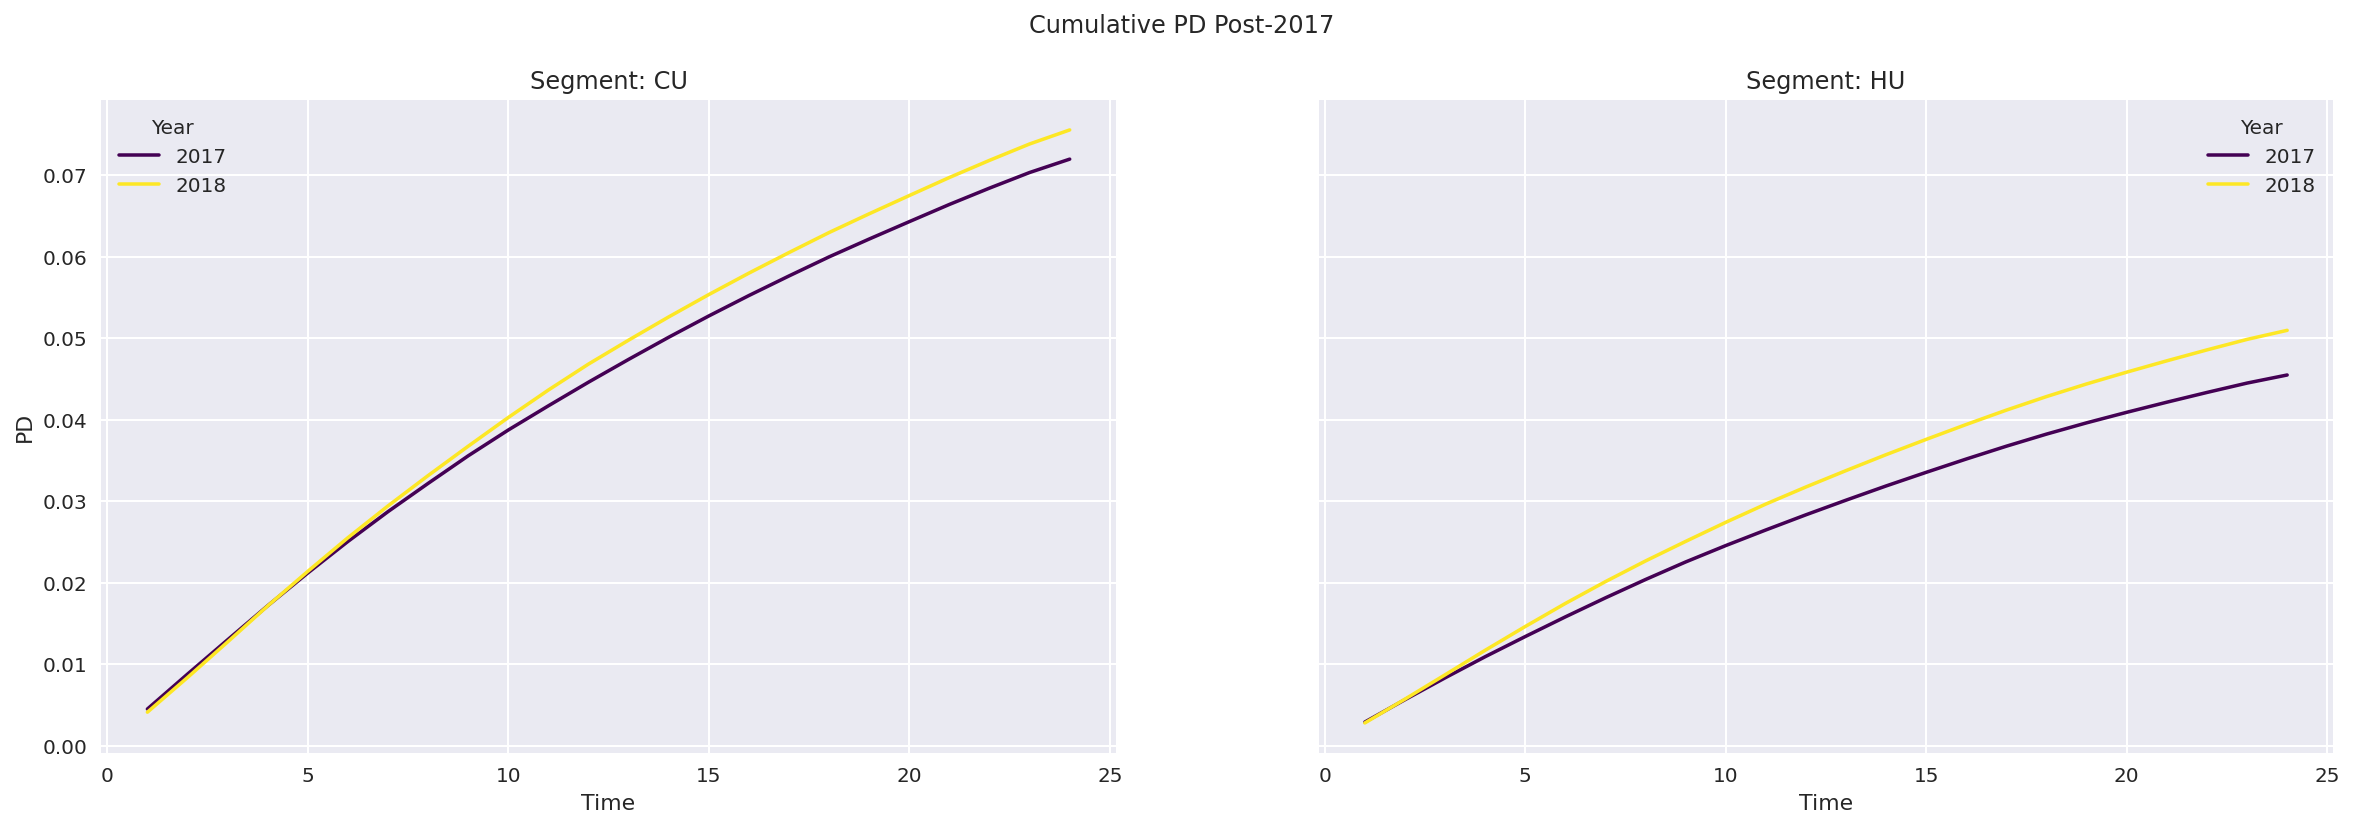

In [30]:
# Plot Chain Ladder for PD of post-2017
plotPD(dfImputed, average = True, year = True)

In [31]:
# Weighted average by segment
averageImputed = weightedAverage(dfImputed, level = 'Segment')
averageImputed

,Segment,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,CU,764536,0.004329,0.008592,0.012880,0.017182,0.021307,0.025300,0.029080,0.032672,0.036164,0.039509,0.042677,0.045718,0.048581,0.051364,0.054039,0.056607,0.059070,0.061468,0.063711,0.065895,0.068057,0.070109,0.072070,0.073751
1,HU,1889138,0.002874,0.005700,0.008519,0.011305,0.013986,0.016592,0.019088,0.021470,0.023737,0.025901,0.027968,0.029939,0.031832,0.033676,0.035442,0.037166,0.038826,0.040392,0.041851,0.043214,0.044523,0.045786,0.046999,0.048046


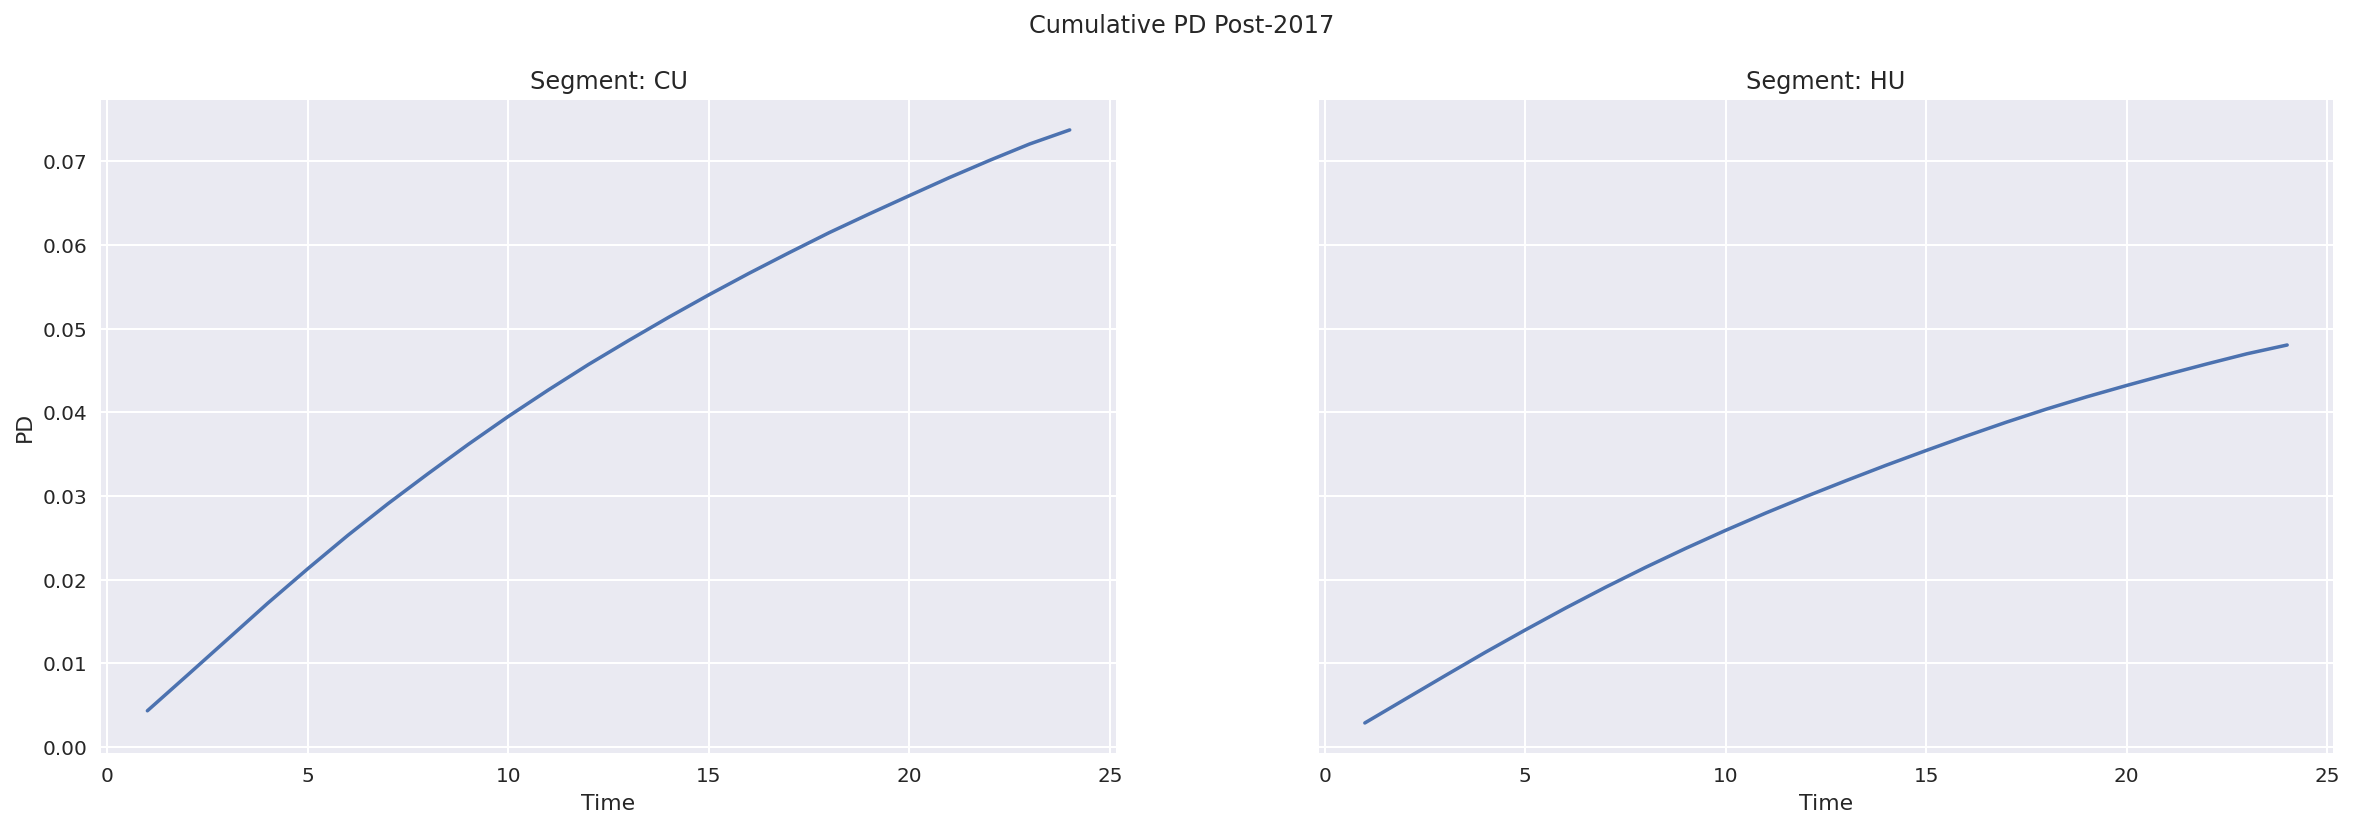

In [32]:
# Plot weighted average with Chain Ladder PD of post-2017
plotPD(averageImputed, average = True, year = False)

In [33]:
# Reference PD Curves
# Using Moody's PD Curves
# CU: B3 Rating
# HU: B2 Rating

# Import Moody's data
refPD = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/refPD.csv')
refPD

,Segment,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
0,B3,0.004584,0.009167,0.013751,0.018335,0.022918,0.027502,0.032086,0.036669,0.041253,0.045837,0.050420,0.055004,0.060482,0.065959,0.071436,0.076914,0.082391,0.087869,0.093346,0.098824,0.104301,0.109778,0.115256,0.120733,0.126234,0.131735,0.137236,0.142736,0.148237,0.153738,0.159239,0.164740,0.170240,0.175741,0.181242,0.186743,0.191398,0.196053,0.200708,0.205363,0.210018,0.214673,0.219328,0.223983,0.228638,0.233293,0.237948,0.242603,0.246815,0.251027,0.255238,0.259450,0.263662,0.267873,0.272085,0.276296,0.280508,0.284720,0.288931,0.293143,0.297014,0.300886,0.304757,0.308629,0.312500,0.316372,0.320243,0.324115,0.327986,0.331858,0.335729,0.339601
1,B2,0.002840,0.005679,0.008519,0.011358,0.014198,0.017037,0.019876,0.022716,0.025556,0.028395,0.031235,0.034074,0.038427,0.042780,0.047133,0.051486,0.055839,0.060192,0.064545,0.068898,0.073251,0.077604,0.081957,0.086310,0.090700,0.095090,0.099480,0.103869,0.108259,0.112649,0.117039,0.121429,0.125819,0.130209,0.134599,0.138989,0.143019,0.147048,0.151078,0.155108,0.159137,0.163167,0.167197,0.171226,0.175256,0.179286,0.183315,0.187345,0.190812,0.194279,0.197746,0.201213,0.204681,0.208148,0.211615,0.215082,0.218549,0.222016,0.225484,0.228951,0.232215,0.235479,0.238743,0.242007,0.245271,0.248535,0.251799,0.255063,0.258326,0.261590,0.264854,0.268118


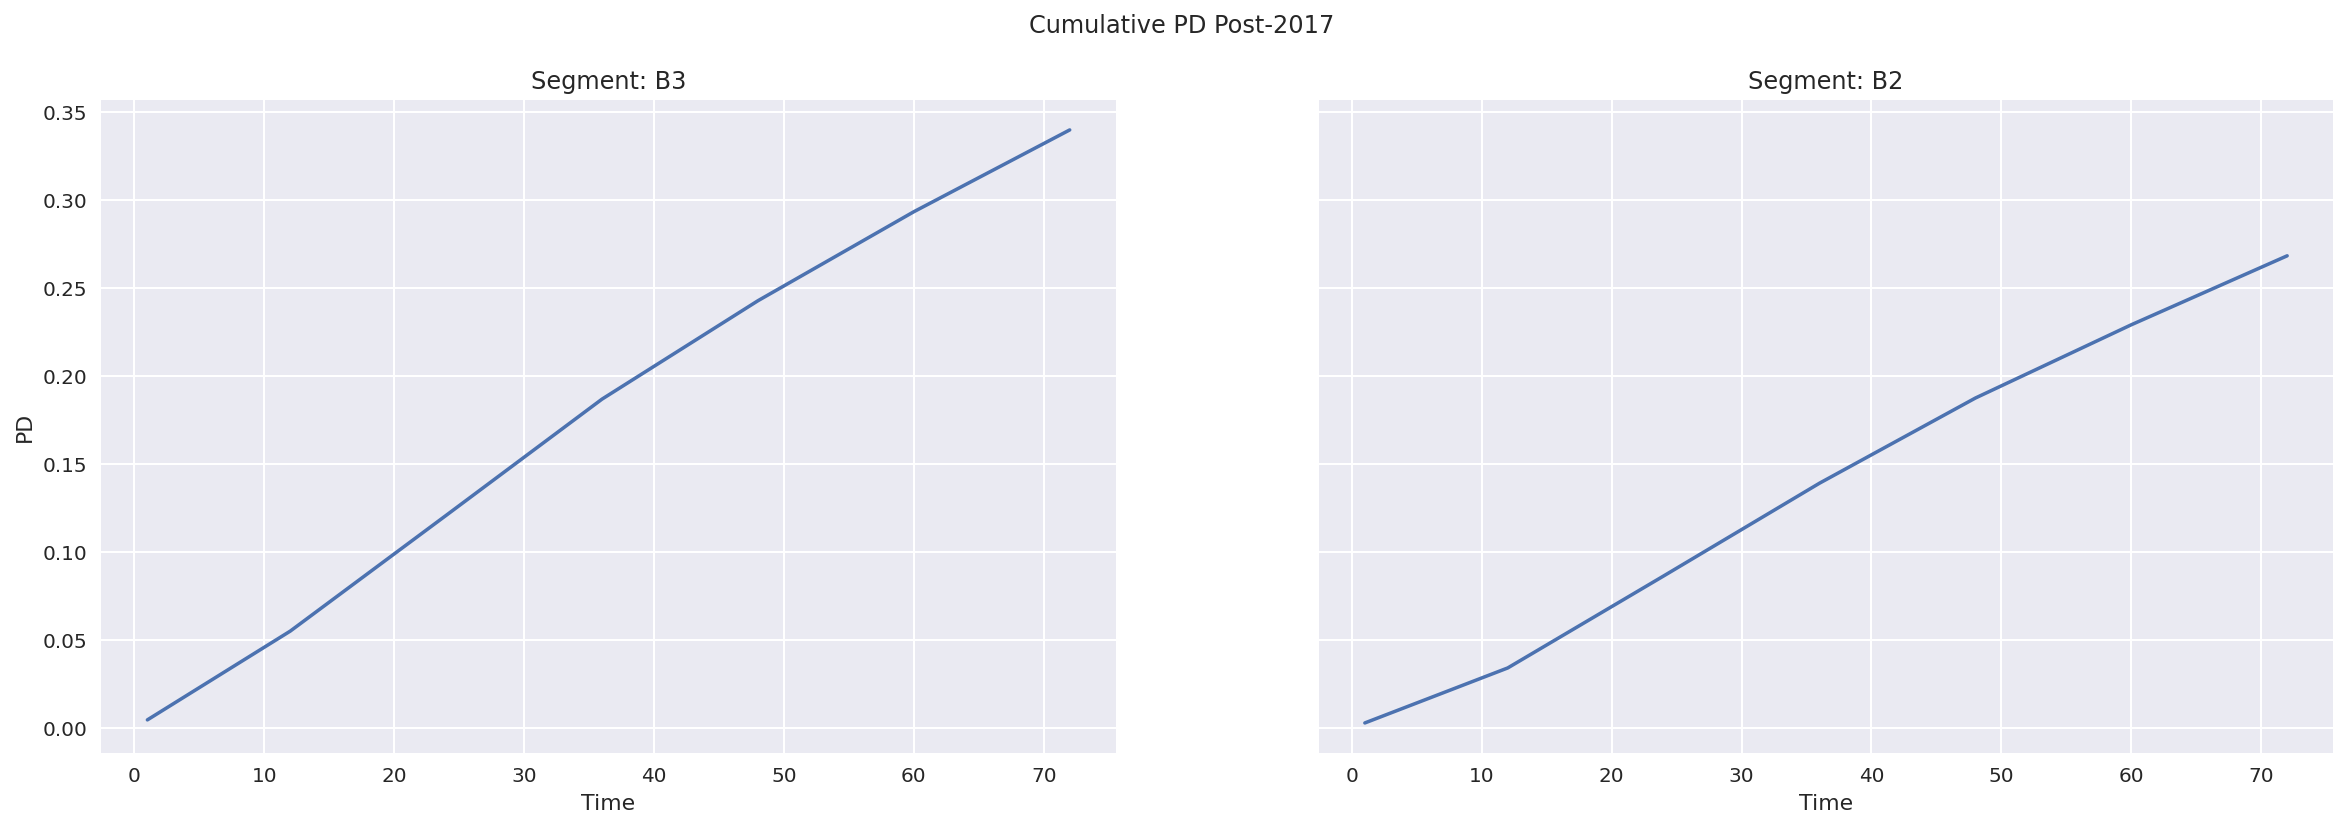

In [34]:
# Plot Moody's PD Curves as reference
plotPD(refPD, average = True, year = False, proxy = True)

In [35]:
# PD Extrapolation using Central Tendency
extrapolatedResults = None

for segment, rating in zip(averageImputed['Segment'].unique(), refPD['Segment'].unique()):
  ttc = averageImputed.query('Segment == @segment').drop(['Segment', 'N'], axis = 1).values[0]
  ref = refPD.query('Segment == @rating').drop(['Segment'], axis = 1).values[0]
  target = ref[ttc.shape[0] - 1] #Starting point for target in the reference curves
  based = ttc[ttc.shape[0] - 1] #Maximum TTC Avaliable for based value
  extrapolatedPD = None
  for i in range(ref.shape[0]):
    if i <= ttc.shape[0] - 1: #Keep raw value until it is unavalialbe
      extrapolate = ttc[i]
    else:
      extrapolate = (based * (ref[i] / target)) / ((based * (ref[i] / target)) + (((1 - ref[i]) / (1 - target)) * (1 - based))) #CT
    if extrapolatedPD is None:
      extrapolatedPD = extrapolate.copy()
    else:
      extrapolatedPD = np.column_stack((extrapolatedPD, extrapolate))
  if extrapolatedResults is None:
    extrapolatedResults = extrapolatedPD.copy()
  else:
    extrapolatedResults = np.vstack((extrapolatedResults, extrapolatedPD))

# Format to DataFrame
extrapolatedResults = pd.DataFrame(extrapolatedResults)
extrapolatedResults.index = averageImputed['Segment']
extrapolatedResults.columns = extrapolatedResults.columns + 1
extrapolatedResults = extrapolatedResults.reset_index()
extrapolatedResults

,Segment,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
0,CU,0.004329,0.008592,0.012880,0.017182,0.021307,0.025300,0.029080,0.032672,0.036164,0.039509,0.042677,0.045718,0.048581,0.051364,0.054039,0.056607,0.059070,0.061468,0.063711,0.065895,0.068057,0.070109,0.072070,0.073751,0.077300,0.080866,0.084449,0.088050,0.091668,0.095305,0.098959,0.102632,0.106323,0.110032,0.113760,0.117507,0.120692,0.123891,0.127104,0.130330,0.133570,0.136824,0.140092,0.143375,0.146671,0.149982,0.153307,0.156646,0.159680,0.162726,0.165784,0.168855,0.171937,0.175032,0.178139,0.181258,0.184390,0.187535,0.190692,0.193862,0.196788,0.199724,0.202671,0.205629,0.208599,0.211579,0.214571,0.217574,0.220588,0.223613,0.226651,0.229699
1,HU,0.002874,0.005700,0.008519,0.011305,0.013986,0.016592,0.019088,0.021470,0.023737,0.025901,0.027968,0.029939,0.031832,0.033676,0.035442,0.037166,0.038826,0.040392,0.041851,0.043214,0.044523,0.045786,0.046999,0.048046,0.050598,0.053160,0.055734,0.058318,0.060914,0.063521,0.066139,0.068768,0.071409,0.074061,0.076725,0.079401,0.081867,0.084344,0.086830,0.089326,0.091833,0.094349,0.096876,0.099413,0.101961,0.104519,0.107087,0.109666,0.111894,0.114129,0.116372,0.118624,0.120883,0.123151,0.125426,0.127710,0.130002,0.132302,0.134611,0.136928,0.139116,0.141313,0.143516,0.145728,0.147947,0.150173,0.152407,0.154649,0.156899,0.159156,0.161422,0.163695


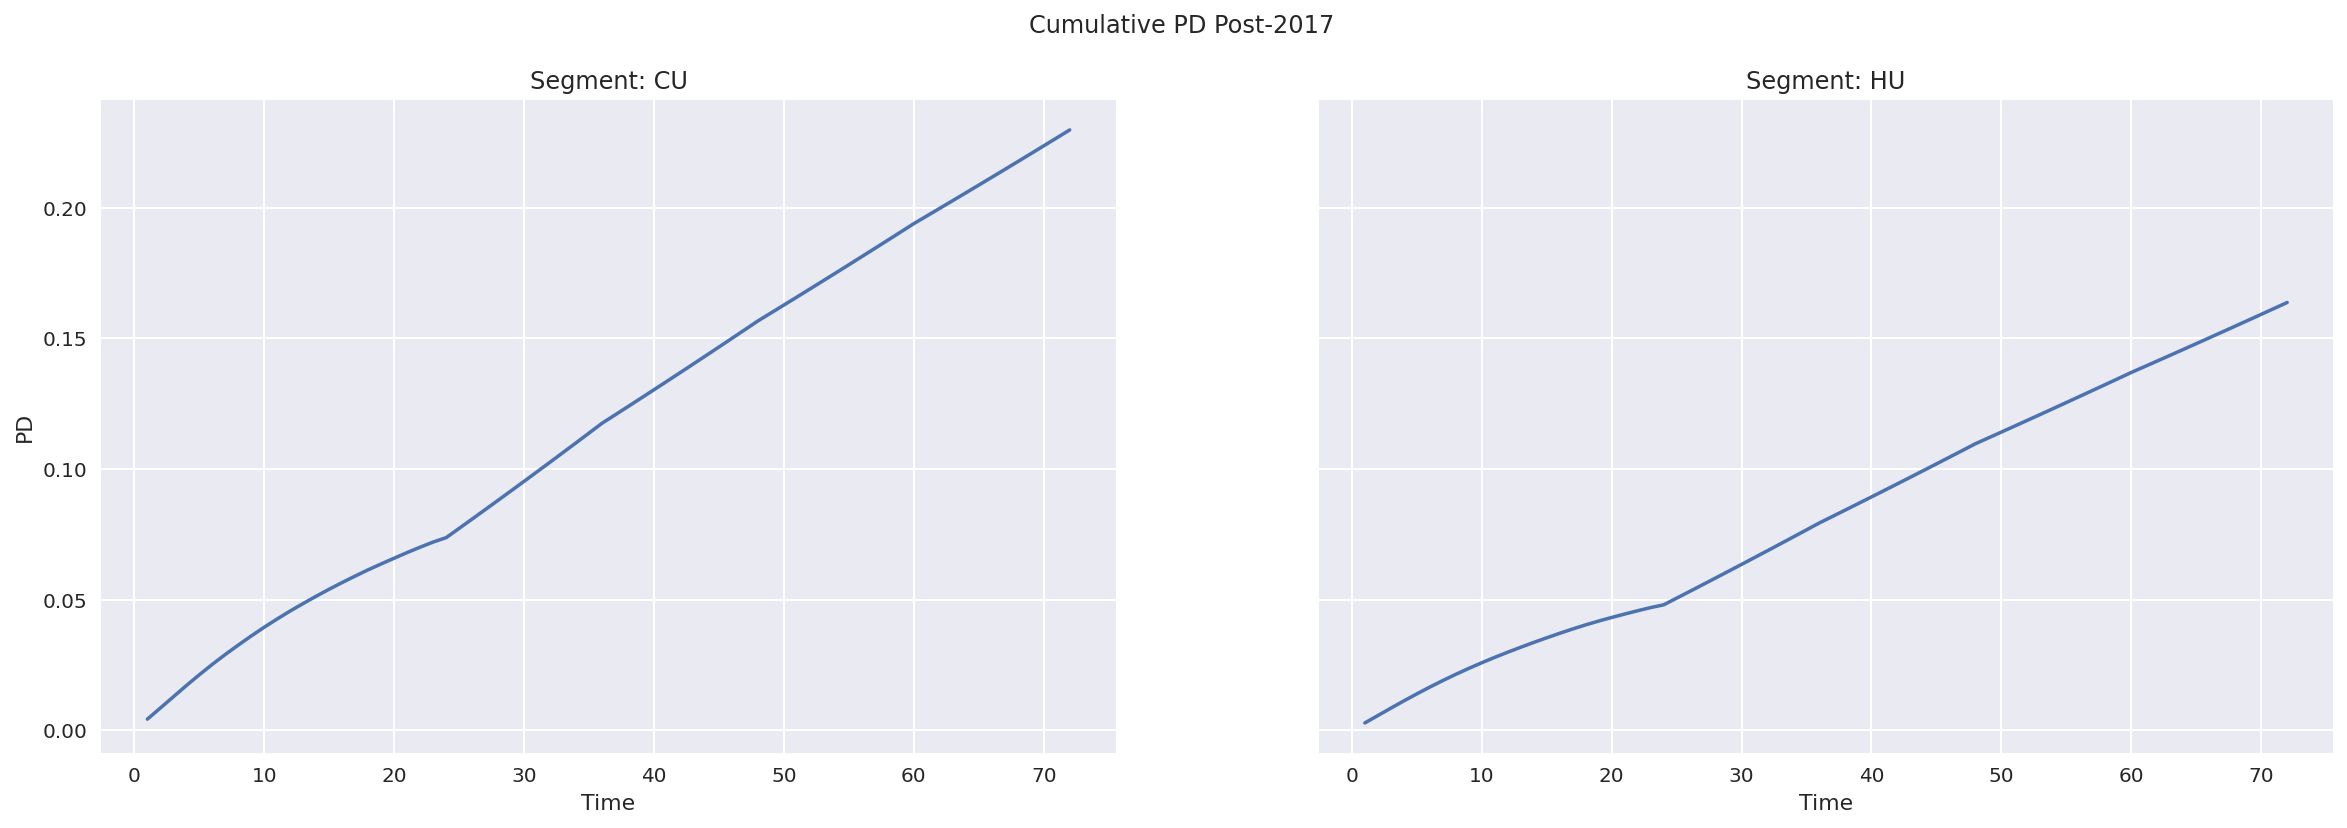

In [36]:
# Plot Moody's PD Curves extrapolation
plotPD(extrapolatedResults, average = True, year = False, proxy = True)

In [37]:
# Plot comparison
# Create table
comparedPD = pd.melt(extrapolatedResults,
                     id_vars = ['Segment'],
                     var_name = 'times', value_name = 'badRate')
comparedPD['times'] = comparedPD['times'].astype(np.int8)
comparedPD['PDTypes'] = 'extrapolatedPD'

refPD = pd.melt(refPD, id_vars = ['Segment'], var_name = 'times', value_name = 'badRate')
refPD['Segment'] = np.where(refPD['Segment'] == 'B3', 'CU', 'HU')
refPD['times'] = refPD['times'].astype(np.int8)
refPD['PDTypes'] = 'referencePD'

comparedPD = pd.concat([comparedPD, refPD], axis = 0, ignore_index = True)
comparedPD = comparedPD.sort_values(by = ['Segment', 'PDTypes', 'times'])
comparedPD

,Segment,times,badRate,PDTypes
0,CU,1,0.004329,extrapolatedPD
2,CU,2,0.008592,extrapolatedPD
4,CU,3,0.012880,extrapolatedPD
6,CU,4,0.017182,extrapolatedPD
8,CU,5,0.021307,extrapolatedPD
...,...,...,...,...
279,HU,68,0.255063,referencePD
281,HU,69,0.258326,referencePD
283,HU,70,0.261590,referencePD
285,HU,71,0.264854,referencePD


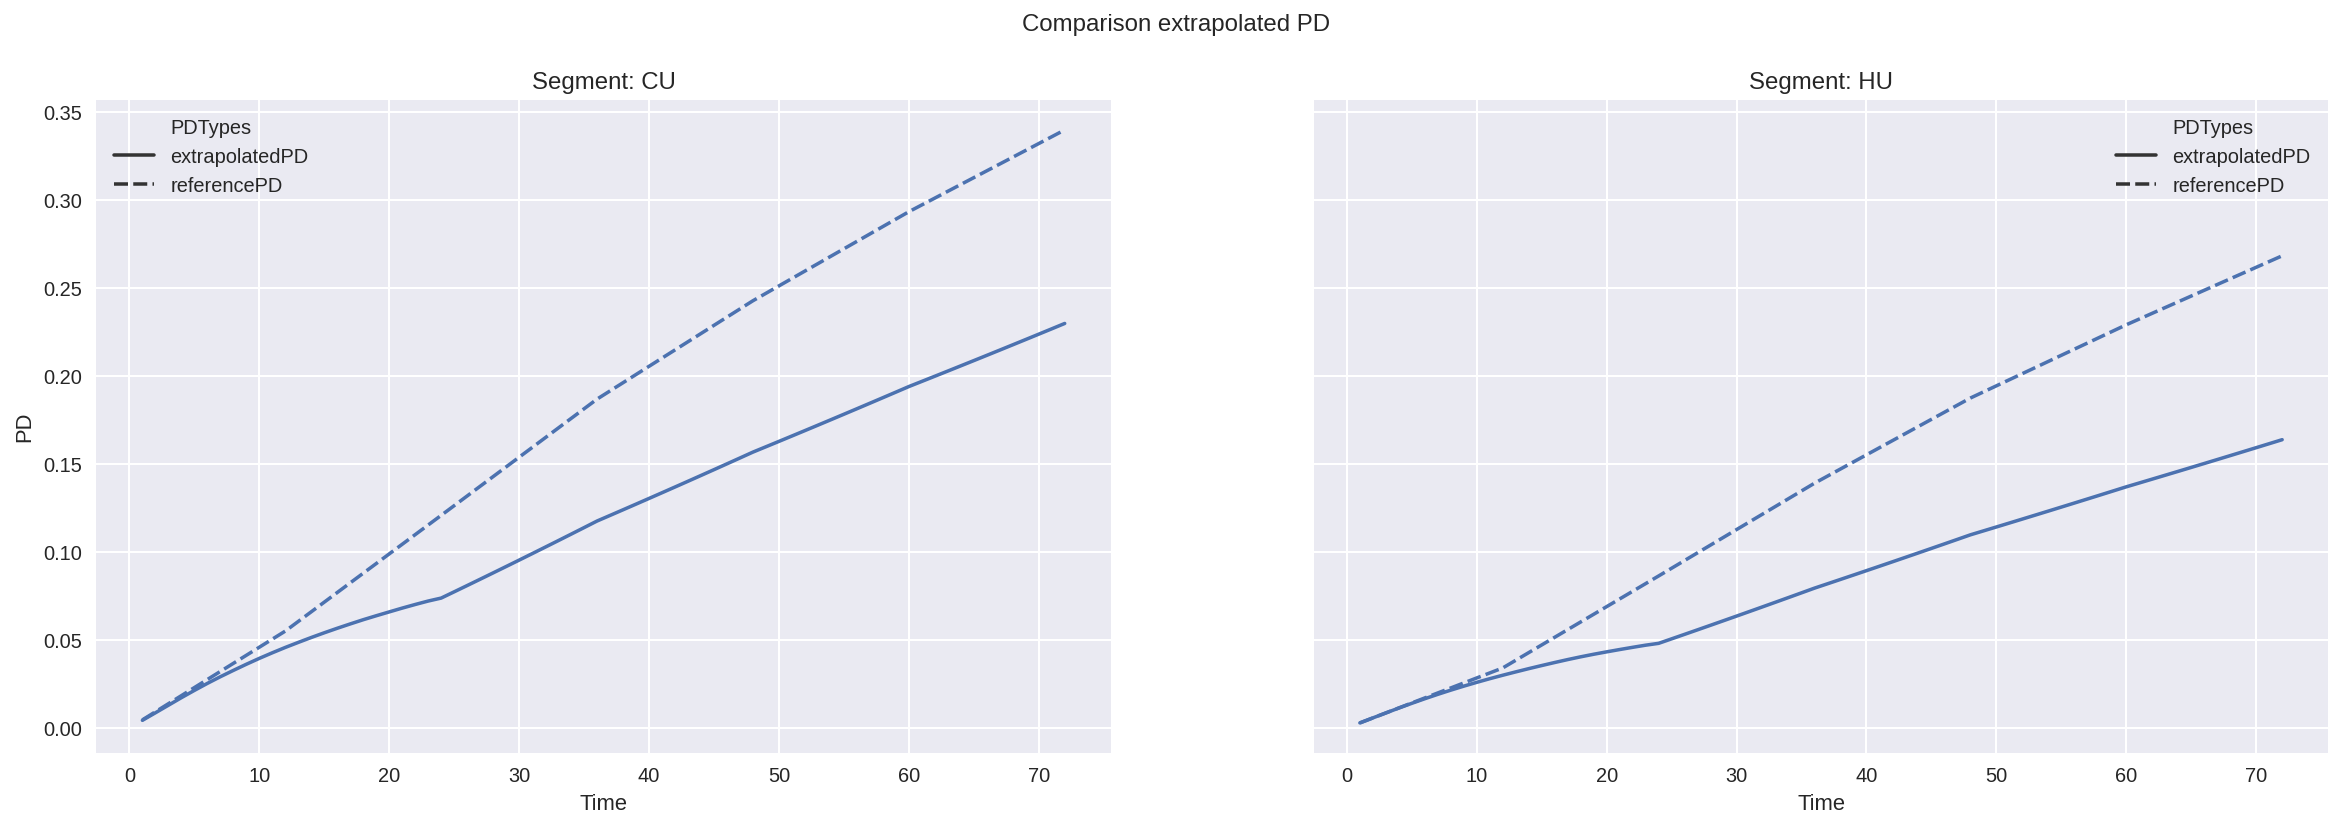

In [38]:
# Plot extrapolation results
with plt.style.context('seaborn'):
  fig, axs = plt.subplots(1, 2, figsize = (20, 6), sharey = True)
  fig.suptitle(f'Comparison extrapolated PD')
  for i, segment in enumerate(comparedPD['Segment'].unique()):
    selectData = comparedPD.query('Segment == @segment')
    sns.lineplot(x = 'times', y = 'badRate', data = selectData,
                  style = 'PDTypes', legend = 'full',
                  palette = 'viridis', ci = None, ax = axs[i])
    axs[i].set_title(f'Segment: {segment}')
    axs[i].set(xlabel = 'Time', ylabel = 'PD')
  plt.show()

In [39]:
# Calibration to risk grade level
# 12-Months OSR as target
averagePD = df[['Segment', 'Aging', 'N', '12']] #Get 12-Month ODR
averagePD = averagePD.groupby(['Segment', 'Aging']).apply(lambda x: np.average(x['12'], weights = x['N']))

for segment in extrapolatedResults['Segment'].unique():
  ttc = extrapolatedResults.query('Segment == @segment').drop(['Segment'], axis = 1).values[0]
  target = ttc[11]
  calibratedResults = None
  for value in range(averagePD.shape[0]):
    bucket = averagePD[value]
    calibratedPD = None
    for i in range(ttc.shape[0]):
      calibrate = (bucket * (ttc[i] / target)) / ((bucket * (ttc[i] / target)) + (((1 - ttc[i]) / (1 - target)) * (1 - bucket)))
      if calibratedPD is None:
        calibratedPD = calibrate.copy()
      else:
        calibratedPD = np.column_stack((calibratedPD, calibrate))
    if calibratedResults is None:
      calibratedResults = calibratedPD.copy()
    else:
      calibratedResults = np.vstack((calibratedResults, calibratedPD))

# Format to DataFrame
calibratedResults = pd.DataFrame(calibratedResults)
calibratedResults.index = averagePD.index
calibratedResults.columns = calibratedResults.columns + 1
calibratedResults = calibratedResults.reset_index()

# Long table format
calibratedResults = pd.melt(calibratedResults,
                            id_vars = ['Segment', 'Aging'],
                            var_name = 'times', value_name = 'badRate')
calibratedResults['times'] = calibratedResults['times'].astype(np.int8)
calibratedResults = calibratedResults.sort_values(by = ['Segment', 'Aging', 'times'])
calibratedResults

,Segment,Aging,times,badRate
0,CU,0,1,0.001593
8,CU,0,2,0.003163
16,CU,0,3,0.004733
24,CU,0,4,0.006289
32,CU,0,5,0.007790
...,...,...,...,...
543,HU,3,68,0.929179
551,HU,3,69,0.930296
559,HU,3,70,0.931388
567,HU,3,71,0.932456


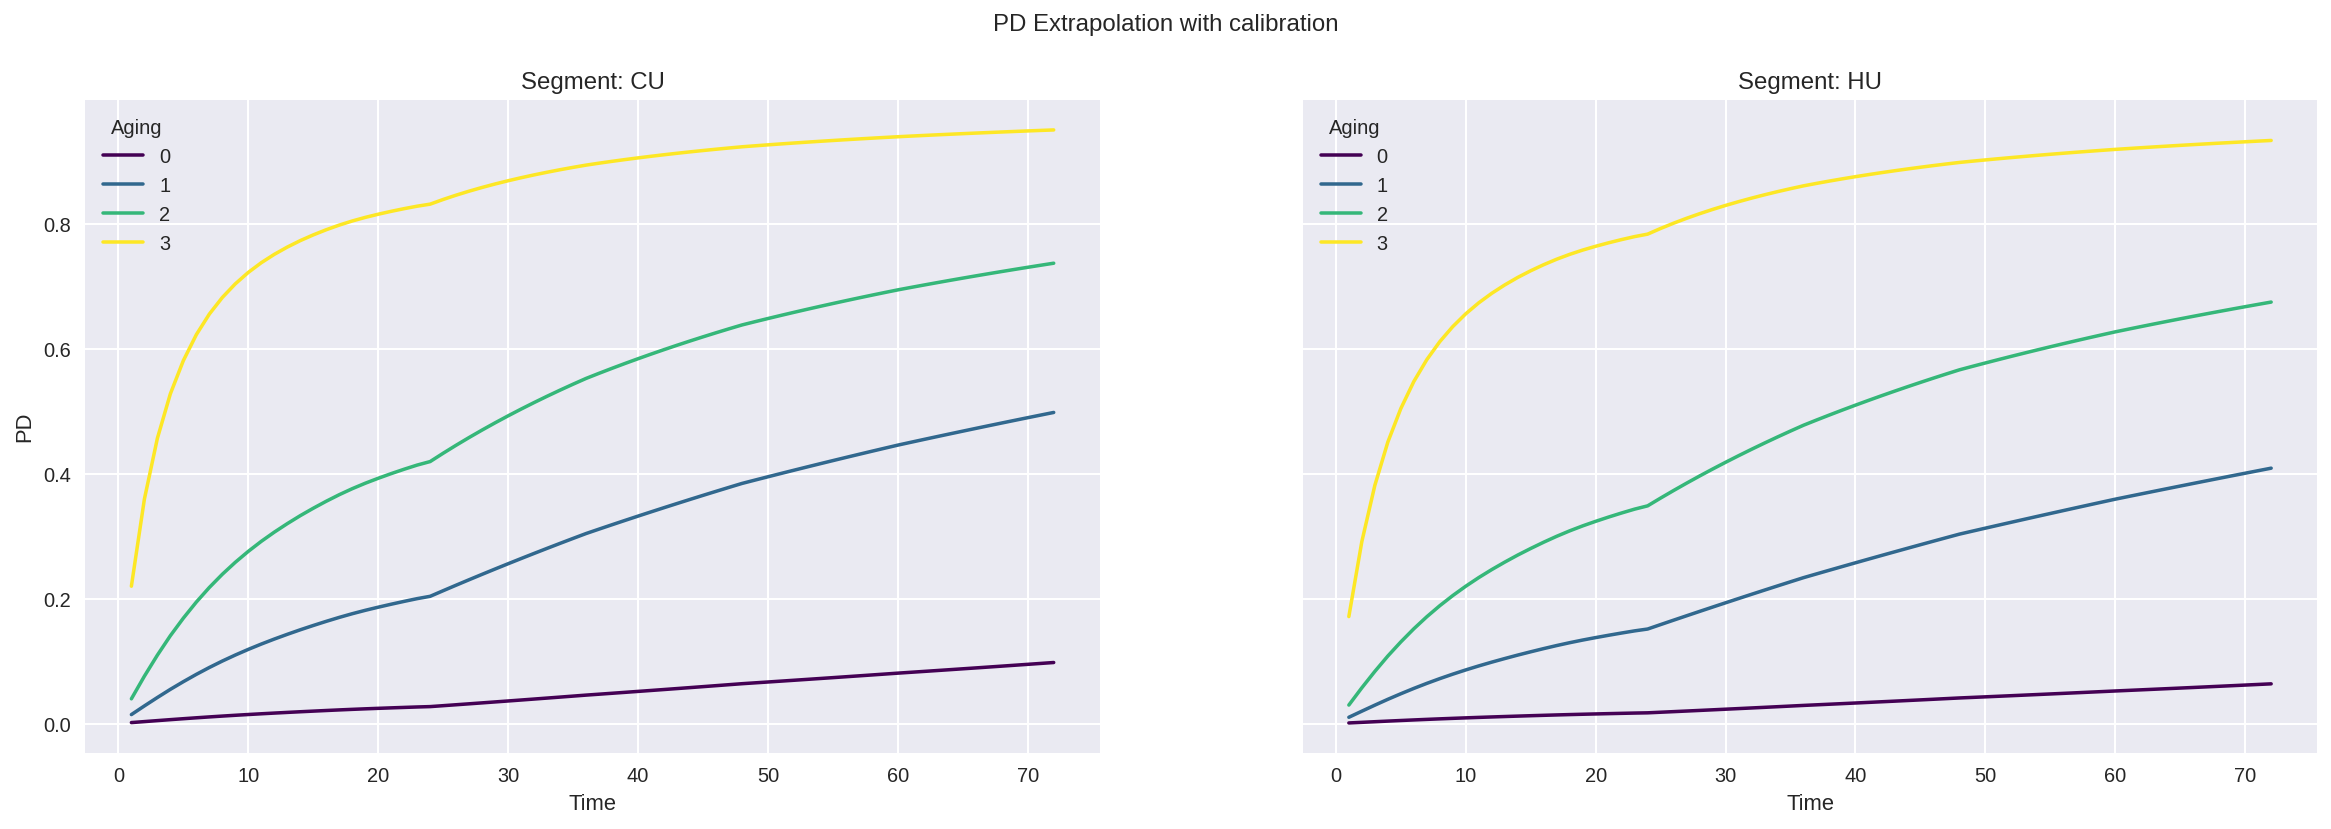

In [40]:
# Plot results
with plt.style.context('seaborn'):
  fig, axs = plt.subplots(1, 2, figsize = (20, 6), sharey = True)
  fig.suptitle(f'PD Extrapolation with calibration')
  for i, segment in enumerate(calibratedResults['Segment'].unique()):
    selectData = calibratedResults.query('Segment == @segment')
    sns.lineplot(x = 'times', y = 'badRate', data = selectData,
                 hue = 'Aging', legend = 'full',
                  palette = 'viridis', ci = None, ax = axs[i])
    axs[i].set_title(f'Segment: {segment}')
    axs[i].set(xlabel = 'Time', ylabel = 'PD')
  plt.show()